<a href="https://colab.research.google.com/github/predatorx7/boring/blob/master/pyai/3_B_AOstar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from collections import OrderedDict
from typing import Any, Dict, List, Set, Tuple
 
 # I should've named this Edge instead
class Connection:
    """Weighted connection between 2 nodes.
    
    Represents the edge between 2 nodes. The weight value is the distance 
    between connectionOf and connectionTo nodes
    """
    def __init__(this, connectionOf: str, connectionTo: str, weight: int = None) -> None:
        this.connectionOf, this.connectionTo = connectionOf, connectionTo
        this.weight = weight
 
    def create_with_swapped_nodes(this):
        return Connection(this.connectionTo, this.connectionOf, this.weight)
 
    def __eq__(this, o):
        if not isinstance(o, Connection):
            return False
        return this.connectionOf == o.connectionOf and this.connectionTo == this.connectionTo and this.weight == this.weight
 
    def __str__(this):
        return f"Connection(Of:{this.connectionOf}, To:{this.connectionTo}, weight:{this.weight})"
 
    def __hash__(this):
        return hash(this.__str__())
 
 
class NodeData:
    "Data of [label] with [value] and list of [connections]"
    def __init__(this, label: str, value=None, connections: Set[Connection] = None) -> None:
        assert isinstance(label, str)
        this.label = label
        this.value = value
        this.connections: Set[Connection] = connections if connections != None else set(
        )
 
    def add_node(this, connectionTo: str, weight: int = None):
        assert connectionTo != None and isinstance(connectionTo, str)
        this.connections.add(Connection(this.label, connectionTo, weight))
 
    def add_connection(this, connection: Connection):
        assert connection.connectionOf == this.label, f"Connection doesn't belong to node {this.label}"
        this.connections.add(connection)
 
    def has_connection(this, connectionTo, weight: int = None):
        for i in this.connections:
            if i.connectionTo == connectionTo and i.weight == weight:
                return True
        return False
 
    def get_connection_with(this, connectionTo: str, weight=None):
        for i in this.connections:
            if i.connectionTo == connectionTo and (weight == None or i.weight == weight):
                return i
        return None

In [ ]:
class Graph:
    """In this [Graph], nodes are stateless and the data is handled by NodeData"""
    def __init__(this) -> None:
        "label: str = value: NodeData | None"
        this._nodes: OrderedDict[str, NodeData] = OrderedDict()

    @property
    def get_nodes(this) -> Tuple[str]:
        return tuple(this._nodes.keys())

    @property
    def first(this) -> str:
        _nodes = this.get_nodes
        if len(_nodes) < 1:
            return None
        return _nodes[0]

    @property
    def items(this):
        return this._nodes.items()

    def __contains__(this, key: object) -> bool:
        return key in this._nodes

    def add_node(this, key, value=None, connections=None):
        assert isinstance(key, str)
        if key in this:
            return
        this._nodes[key] = NodeData(key, value, connections)

    def get_data(this, key):
        return this._nodes.get(key, None)

    def add_connection(this, connection: Connection, is_birectional: bool = None):
        a, b = connection.connectionOf, connection.connectionTo
        this.add_node(a)
        this.add_node(b)
        data_a = this.get_data(a)
        data_a.add_connection(connection)
        if is_birectional:
            data_b = this.get_data(b)
            data_b.add_connection(connection.create_with_swapped_nodes())

    def add_connection_as(this, connectionOf, connectionTo, weight, is_birectional: bool = None):
        this.add_connection(Connection(
            connectionOf, connectionTo, weight), is_birectional)

    def add_connections(this, connections: List[Connection], is_birectional: bool = None):
        for i in connections:
            this.add_connection(i, is_birectional)

    def add_connections_as(this, connections: List[tuple], weight=None, is_birectional: bool = None):
        """Add multiple connection from list of tuples where
        every tuple must be (connectionOf: str, connectionTo: str, weight: int)

        The weight parameter overrides weight value in tuple"""
        for connectionOf, connectionTo, _weight in connections:
            assert isinstance(connectionOf, str) and isinstance(
                connectionTo, str)
            _eff_weight = weight if weight != None else _weight
            this.add_connection_as(
                connectionOf,  connectionTo, _eff_weight, is_birectional)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pylab

# unnecessary methods for graph building & presentation purpose

def graph_builder(connections: List[tuple], is_birectional=False) -> Graph:
    """The [connections] is a list of tuples where every tuple must be (connectionOf: str, connectionTo: str, weight: int)
    for example:
    ```
    edge_connections: List[tuple] = [
        ('S', 'B', 4),
        ('S', 'C', 3),
        ('C', 'D', 7),
        ('D', 'E', 2),
        ('C', 'E', 10),
        ('B', 'E', 12),
        ('B', 'F', 5),
        ('F', 'G', 16),
        ('E', 'G', 5)
    ]
    ```
    """
    assert isinstance(is_birectional, bool), "is_birectional must be bool"

    G = Graph()

    # Add edges to graph
    G.add_connections_as(connections, is_birectional=True)
    return G


def draw_graph(graph: Graph, start: str = None, goal: str = None, path: Tuple[str] = None):
    "Creates a directed Networkx graph"
    G = nx.DiGraph()
    for i in graph.get_nodes:
        data = graph.get_data(i)
        for j in data.connections:
            G.add_edge(i, j.connectionTo, weight=j.weight)

    # set colors to special nodes (start, goal, path)
    val_map = dict()
    if start != None:
        val_map[start] = 0.0
    if goal != None:
        val_map[goal] = 1.0
    if path != None:
        for i in path[1:-1]:
            val_map[i] = 0.75

    # set colors of other nodes to 0.25 which are not in val_map
    values = [val_map.get(node, 0.5) for node in G.nodes()]
    edge_labels = dict([((u, v,), d['weight'])
                        for u, v, d in G.edges(data=True)])

    options = {
        'node_color': values,
        'node_size': 1500,
        'edge_color': 'black',
        'width': 1,
        'arrowstyle': '-|>',
        'arrowsize': 12,
        'edge_cmap': plt.cm.Reds
    }

    pos = nx.spring_layout(G)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    nx.draw_networkx(G, pos, arrows=True, **options)
    pylab.show()

In [ ]:
from math import inf

class Astar():
    def __init__(this, graph: Graph) -> None:
        "Informed Search"

        this.graph = graph

    def g(this, n: str, connection_with_n: Connection = None):
        """G is the cost of moving from one node to the other node. 
        This parameter changes for every node as we move up to find the most optimal path."""

        assert this.current != None, "current variable must have a value"

        if this.current == n:
            return 0

        if connection_with_n == None:
            current_node_data = this.graph.get_data(this.current)
            connection_with_n = current_node_data.get_connection_with(n)

        assert connection_with_n != None, "current has no direct connection with n"

        return this.g_score.get(this.current, inf) + connection_with_n.weight

    def _calculate_heuristic_by_dfs(this, n: str, g: str):
        if not n in this._visited_nodes_in_heuristic_calculation:
            this._visited_nodes_in_heuristic_calculation.add(n)

        if n == g:
            return 0

        data = this.graph.get_data(n)
        if data.value != None:
            return data.value

        for connection in data.connections:
            child = connection.connectionTo
            if child == g:
                # this is g, return weight
                data.value = connection.weight
                break
            if child in this._visited_nodes_in_heuristic_calculation:
                # Had been visited and doesn't have g.
                # if it has g, then the value should have already been returned above,
                # but it didn't. Thus, it doesn't have g.
                continue
            value = this._calculate_heuristic_by_dfs(child, g)
            if value == None:
                # Did not found goal in depth
                continue
            # Found goal
            data.value = value + connection.weight
            break
        return data.value

    def h(this, n: str):
        """H is the heuristic/estimated path between the current code to the destination node. 
        This cost is not actual but is, in reality, a guess cost that we use to find 
        which could be the most optimal path between our source and destination."""
        return this._calculate_heuristic_by_dfs(n, this.goal)

    def f(this, n: str):
        """F is the parameter of A* which is the sum of the other parameters 
        G and H and is the least cost from one node to the next node. 
        This parameter is responsible for helping us find the most optimal 
        path from our source to destination."""
        
        # Uses cached value of g if available
        g = this.g_score.get(n, inf)
        h = this.h(n)
          f = g + h
        if h == None:
          return inf
        return g + h

    @property
    def reconstruct_path(this) -> Tuple[str]:
        "Reconstruct path from current"
        current = this.current
        absolute_path = [current]
        while current in this.came_from:
            current = this.came_from[current]
            absolute_path.insert(0, current)
        return tuple(absolute_path)

    def execute(this, start: str, goal: str) -> Tuple[int, str]:
        """
        A* search algorithm. Returns a tuple of minimum cost and shortest path to travel from start to goal.

        Reference: https://en.wikipedia.org/wiki/A*_search_algorithm
        """
        this.start = start
        this.goal = goal

        # ignore, this set is used by heuristic function
        this._visited_nodes_in_heuristic_calculation: Set[str] = set()

        # The set of discovered nodes that may need to be(re-)expanded.
        # Initially, only the start node is known.
        open_nodes = {start}

        # For node n, cameFrom[n] is the node immediately preceding it
        # on the cheapest path from start to n currently known.
        this.came_from: Dict[str, str] = dict()

        # For node n, g_score[n] is the cost of the cheapest path from start to n currently known.
        # If None, then assume default value to be inf
        this.g_score: Dict[str, int] = dict()
        this.g_score[start] = 0

        # For node n, f_score[n] = g_score[n] + h(n).
        # f_score[n] represents our current best guess as to
        # how short a path from start to finish can be if it goes through n.
        # map has with default value of Infinity
        this.f_score: Dict[str, int] = dict()
        this.f_score[start] = this.h(start)

        def open_node_with_lowest_f_score():
            # This operation can occur in O(1) time if open_nodes is a min-heap or a priority queue
            lowest_key = None
            lowest_val = None
            for k in open_nodes:
                v = this.f_score[k]
                if lowest_key == None and lowest_val == None:
                    lowest_key, lowest_val = k, v
                    continue
                if v < lowest_val:
                    lowest_key, lowest_val = k, v
            return lowest_key

        while len(open_nodes) != 0:
            # the node in open_nodes set having the lowest fScore[] value
            this.current = open_node_with_lowest_f_score()
            if this.current == goal:
                return (this.f_score[this.current], this.reconstruct_path)

            open_nodes.remove(this.current)

            current_data = this.graph.get_data(this.current)
            for connection in current_data.connections:
                neighbor = connection.connectionTo
                # tentative_g_score = g(neighbour) = g(current) + d(current, neighbor)
                # where d is the weight of the edge from current to neighbor
                # tentative_gScore is the distance from start to the neighbor through current
                tentative_g_score = this.g(neighbor, connection)
                previous_g_score = this.g_score.get(neighbor, inf)
                if tentative_g_score < previous_g_score:
                    # This path to neighbor is better than any previous one. Record it!
                    this.came_from[neighbor] = this.current
                    this.g_score[neighbor] = tentative_g_score
                    this.f_score[neighbor] = this.f(neighbor)
                    if neighbor not in open_nodes:
                        open_nodes.add(neighbor)
        # // open_nodes set is empty but goal was never reached
        return None

## Example 1

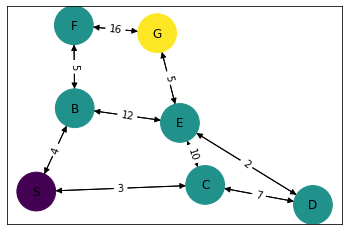

In [ ]:
# Creating a graph below

# edges
_connections: List[tuple] = [
    ('S', 'B', 4),
    ('S', 'C', 3),
    ('C', 'D', 7),
    ('D', 'E', 2),
    ('C', 'E', 10),
    ('B', 'E', 12),
    ('B', 'F', 5),
    ('F', 'G', 16),
    ('E', 'G', 5)
]

graph = graph_builder(_connections)

draw_graph(graph, start='S', goal='G')

In [ ]:
# Executing A* search algorithm on graph

astar = Astar(graph)

cost, optimum_path = astar.execute("S", "G")

print(f"Optimum path: {' -> '.join(optimum_path)}")

print(f'\nMinimum cost: {cost}')

Optimum path: S -> C -> D -> E -> G

Minimum cost: 17


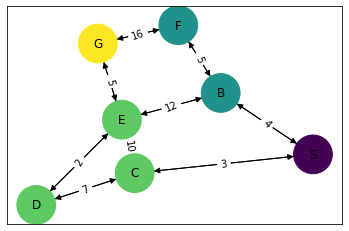

In [ ]:
draw_graph(graph, "S", "G", path=optimum_path)

## Example 2

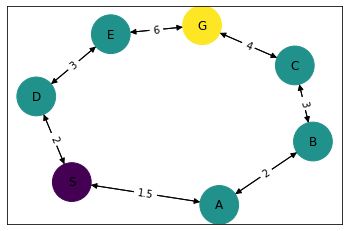

In [ ]:
# Creating a graph below
f = g + h
# edges
_connections: List[tuple] = [
    ('S', 'A', 1.5),
    ('A', 'B', 2),
    ('B', 'C', 3),
    ('C', 'G', 4),
    ('S', 'D', 2),
    ('D', 'E', 3),
    ('E', 'G', 6), #2),
]

graph = graph_builder(_connections)

draw_graph(graph, start='S', goal='G')

In [ ]:
# Executing A* search algorithm on graph

astar = Astar(graph)

cost, optimum_path = astar.execute("S", "G")

print(f"Optimum path: {' -> '.join(optimum_path)}")

print(f'\nMinimum cost: {cost}')

Optimum path: S -> A -> B -> C -> G

Minimum cost: 10.5


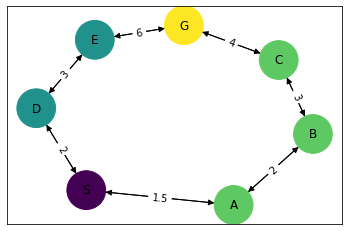

In [ ]:
draw_graph(graph, "S", "G", path=optimum_path)